In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Attention, Concatenate, Input



In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load and prepare data
df = pd.read_csv("INTC_Stock.csv", index_col='Date', parse_dates=True)
df['Target'] = df['Close'].shift(-1) / df['Close'] - 1
df = df.dropna()

X = df.drop(['Target', 'Close', 'High', 'Low', 'Open'], axis=1)
y = df['Target']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust feature selection parameters
def correlation_selection(X, y, threshold=0.01):  # Lowered from 0.1
    correlations = pd.Series(abs(np.corrcoef(X, y, rowvar=False)[:-1, -1]), 
                           index=X.columns)
    selected = correlations[correlations > threshold].sort_values(ascending=False)
    print("\nFeature correlations with target:")
    print(selected)
    return selected.index.tolist()

def rf_importance_selection(X, y, threshold=0.005):  # Lowered from 0.01
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nRandom Forest feature importances:")
    print(importances)
    return importances[importances > threshold].index.tolist()

def mutual_info_selection(X, y, k=15):  # Increased from 10
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    selector.fit(X, y)
    scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
    print("\nMutual Information scores:")
    print(scores)
    return X.columns[selector.get_support()].tolist()

# Apply updated selection methods
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
corr_features = correlation_selection(X_train_df, y_train)
mi_features = mutual_info_selection(X_train_df, y_train)
rf_features = rf_importance_selection(X_train_df, y_train)

# Find common features
common_features = list(set(corr_features) & set(mi_features) & set(rf_features))
print("\nCommon features:", common_features)
print("Correlation-based features:", corr_features)
print("\nMutual Information features:", mi_features)
print("\nRandom Forest important features:", rf_features)
print("\nCommon features:", list(set(corr_features) & set(mi_features) & set(rf_features)))


Feature correlations with target:
Volume           0.040855
BB_Upper         0.036610
R1               0.036318
S1               0.035824
BB_Middle        0.035565
PIVOT            0.035035
SAR              0.034471
BB_Lower         0.034300
EMA_20           0.033346
SMA_20           0.033293
STDDEV           0.033105
MACD_Signal      0.032775
ICHIMOKU_CONV    0.032414
MACD             0.032156
OBV              0.028921
AD               0.023382
PLUS_DI          0.022417
ATR              0.018738
RSI              0.012526
ROC              0.011574
dtype: float64

Mutual Information scores:
S1               0.065821
STDDEV           0.058102
R1               0.055635
AD               0.054620
PIVOT            0.049751
ATR              0.045215
SAR              0.040596
MACD_Signal      0.039180
EMA_20           0.038312
SMA_20           0.037469
BB_Upper         0.032956
BB_Middle        0.029178
OBV              0.022549
BB_Lower         0.016395
MACD             0.013399
Volume      

In [5]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'EMA_20', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'SAR',
       'RSI', 'STOCH_K', 'STOCH_D', 'WILLR', 'ROC', 'OBV', 'AD', 'MFI', 'ATR',
       'STDDEV', 'ADX', 'PLUS_DI', 'MINUS_DI', 'ICHIMOKU_CONV', 'PIVOT', 'R1',
       'S1', 'Target'],
      dtype='object')

In [12]:
selected_features = ['BB_Upper', 'STDDEV', 'SAR', 'BB_Middle', 'R1', 'BB_Lower', 
                    'OBV', 'S1', 'SMA_20', 'AD', 'MACD_Signal', 'EMA_20', 
                    'ATR', 'MACD', 'PIVOT']

selected_features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'EMA_20', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'SAR',
       'RSI', 'STOCH_K', 'STOCH_D', 'WILLR', 'ROC']

In [13]:
def prepare_features(df, selected_features):
    X = df[selected_features]
    y = df['Close'].shift(-1) / df['Close'] - 1
    
    # Remove NaN values
    X = X.dropna()
    y = y[X.index]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), 
                          columns=X.columns, 
                          index=X.index)
    
    return X_scaled, y

X_final, y_final = prepare_features(df, selected_features)

In [14]:

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def build_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    
    lstm1 = LSTM(256, return_sequences=True)(inputs)
    bn1 = BatchNormalization()(lstm1)
    drop1 = Dropout(0.4)(bn1)
    
    lstm2 = LSTM(128, return_sequences=True)(drop1)
    attention = Attention()([lstm2, lstm2])
    bn2 = BatchNormalization()(attention)
    drop2 = Dropout(0.3)(bn2)
    
    lstm3 = LSTM(64)(drop2)
    bn3 = BatchNormalization()(lstm3)
    
    dense1 = Dense(32, activation='elu')(bn3)
    output = Dense(1)(dense1)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Prepare data
X_seq, y_seq = create_sequences(X_final.values, y_final.values)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Model with GPU optimization
with tf.device('/GPU:0'):
    model = build_attention_model((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='huber')
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.00001)
    ]

    history = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=32,
                      callbacks=[
                          tf.keras.callbacks.EarlyStopping(patience=15),
                          tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
                      ])
# Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2853 - val_loss: 0.0021 - learning_rate: 3.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0595 - val_loss: 0.0063 - learning_rate: 3.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0313 - val_loss: 0.0036 - learning_rate: 3.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0202 - val_loss: 0.0029 - learning_rate: 3.0000e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - val_loss: 0.0059 - learning_rate: 3.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0113 - val_loss: 0.0068 - learning_rate: 3.0000e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0090 - val_loss: 0.0025 - learning_rate: 1.5000e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0082 - val_loss: 0.0018 - learning_rate: 1.5000e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0069 - val_loss: 0.0040 - 

Mean Squared Error: 0.005081
Mean Absolute Error: 0.043324
R-squared Score: -5.782291


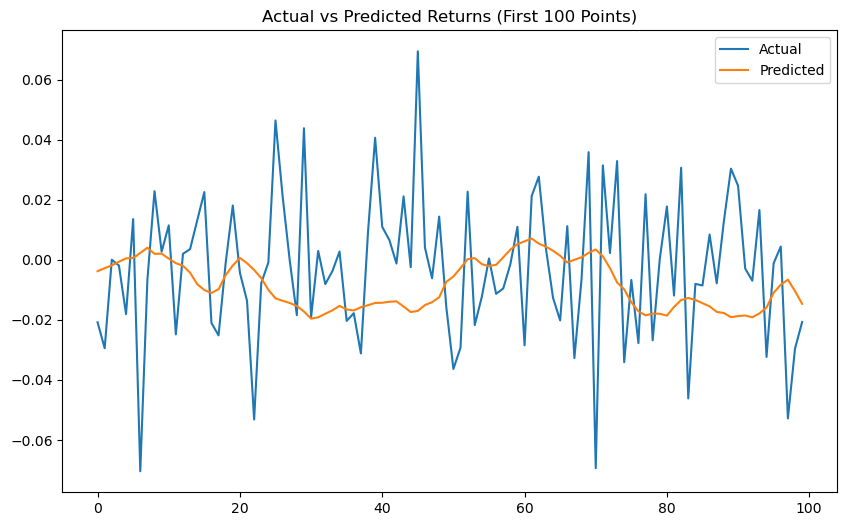

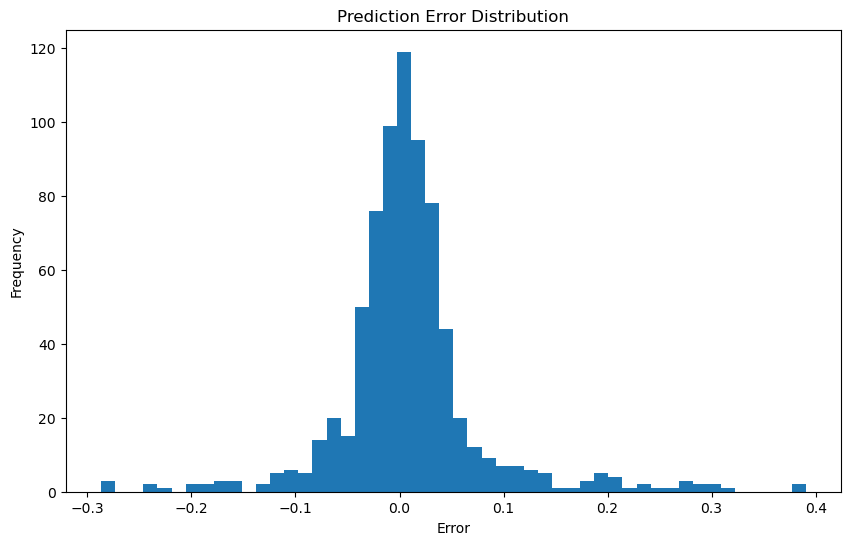

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Remove NaN values
mask = ~np.isnan(y_test)
y_test_clean = y_test[mask]
predictions_clean = predictions[mask]

# Calculate metrics
mse = mean_squared_error(y_test_clean, predictions_clean)
mae = mean_absolute_error(y_test_clean, predictions_clean)
r2 = r2_score(y_test_clean, predictions_clean)

print(f'Mean Squared Error: {mse:.6f}')
print(f'Mean Absolute Error: {mae:.6f}')
print(f'R-squared Score: {r2:.6f}')

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test_clean[:100], label='Actual')  # First 100 points for clarity
plt.plot(predictions_clean[:100], label='Predicted')
plt.title('Actual vs Predicted Returns (First 100 Points)')
plt.legend()
plt.show()

# Plot prediction error distribution
plt.figure(figsize=(10, 6))
plt.hist(y_test - predictions.flatten(), bins=50)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Add buy/sell signal logic
def generate_signals(predictions, threshold=0.0005):
   signals = []
   for pred in predictions:
       if pred > threshold:
           signals.append('BUY')
       elif pred < -threshold:
           signals.append('SELL') 
       else:
           signals.append('HOLD')
           
   return signals

# Make predictions and generate signals
predictions = model.predict(X_test)
signals = generate_signals(predictions)

print(f"y_test_clean length: {len(y_test_clean)}")
print(f"predictions length: {len(predictions)}")
print(f"signals length: {len(signals)}")

# Make sure lengths match
min_length = min(len(y_test_clean), len(predictions), len(signals))

results = pd.DataFrame({
   'Actual_Return': y_test_clean[:min_length],
   'Predicted_Return': predictions.flatten()[:min_length],
   'Signal': signals[:min_length]
})

print("\nResults:")
print(results.head(10))

# Calculate signal accuracy
def calculate_signal_accuracy(results):
   correct = 0
   for actual, pred in zip(results['Actual_Return'], results['Predicted_Return']):
       if (actual > 0 and pred > 0) or (actual < 0 and pred < 0):
           correct += 1
   return correct / len(results)

accuracy = calculate_signal_accuracy(results)
print(f'\nSignal Accuracy: {accuracy:.2%}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
y_test_clean length: 739
predictions length: 740
signals length: 740

Results:
   Actual_Return  Predicted_Return Signal
0      -0.020818         -0.003816   SELL
1      -0.029467         -0.002795   SELL
2       0.000000         -0.001874   SELL
3      -0.001922         -0.000653   SELL
4      -0.018098          0.000453   HOLD
5       0.013529          0.000587    BUY
6      -0.070420          0.002259    BUY
7      -0.006660          0.004000    BUY
8       0.022837          0.001975    BUY
9       0.002663          0.002029    BUY

Signal Accuracy: 52.77%


In [17]:
# Save the model to a file
model.save('third_model.keras')